In [1]:
import MGTomo.model as mgmodel
import time
import numpy as np
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.functions as fcts
from skimage import data
from skimage.transform import resize
from MGTomo.optimize import armijo_linesearch, box_bounds

from MGTomo.gridop import RBox as R, PBox as P

import torch
from torch.func import grad

from torch.linalg import matrix_norm

import matplotlib.pyplot as plt 

In [2]:
max_levels = 4
maxIter = [1,4,16,32,64]

In [3]:
N = 511
# load image
x_orig = data.shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [4]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [5]:
#c0 = A[0].sumnorm()
#tau0 = 0.5 * 1/c0

In [6]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [7]:
#c0 = 56.0952
#tau0 = 0.5 * 1/c0

c0 = 100
tau0 = 0.5 * 1/c0

In [8]:
tau = [tau0]*(max_levels+1)

In [9]:
def coarse_condition_v2(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if gcond:
        if y_last is not None:
            y_diff_norm = matrix_norm(y_last - y)
            y_norm = matrix_norm(y)
            return (y_diff_norm >= eta * y_norm)
        return True
    else:
        return False

In [10]:
def coarse_condition_kl(y, grad_y, kappa, eta, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if y_last is not None:
        y_diff_norm = fcts.kl_distance_no_matrix(y_last, y)
        return gcond and (y_diff_norm >= eta * y.flatten().size()[0])
    else:
        return gcond

In [11]:
def coarse_condition_v3(grad_y, kappa, eps):
    Rgrady = matrix_norm( R(grad_y))
    gcond_rel = (Rgrady >= kappa * matrix_norm(grad_y))
    gcond = (Rgrady >= eps)
    
    return gcond_rel and gcond

In [12]:
def coarse_condition(y, grad_y, kappa, y_last = None):
    gcond = (matrix_norm(R(grad_y)) >= kappa * matrix_norm(grad_y))
    if y_last is not None:
        y_diff_norm = matrix_norm(y_last - y)
        return gcond and (y_diff_norm >= kappa)
    else:
        return gcond

In [13]:
def box_projection(x, l, u):
    mask_l = (x < l)
    proj_x = torch.where(mask_l, x, l)

    mask_u = (x > u)
    proj_x = torch.where(mask_u, proj_x, u)

    return proj_x

In [14]:
def coarse_condition_proj(y, x, lH, uH, lh, uh, kappa):
    proj_x = box_projection(x, lH, uH)
    proj_y = box_projection(y, lh, uh)

    gcond = matrix_norm(proj_x - x) >= kappa * matrix_norm(proj_y - y)

    return gcond

In [15]:
def MLO_box(fh, y, lh, uh, last_pts: list, l=0, kappa = 0.49, eps = 0.001, verbose = True):
    x = R(y).detach().requires_grad_(True)
    y0, x0 = y, x.clone().detach().requires_grad_(True)
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    grad_fhy0 = y0.grad.clone()
    y0.grad.zero_()
    
    if coarse_condition_v2(y, grad_fhy0, kappa, eps, last_pts[l]):
    #if coarse_condition_v3(grad_fhy0, kappa, eps):
        print(l, ' : coarse correction activated')
        last_pts[l] = y0.clone().detach()
    
        fH = lambda x: fcts.kl_distance(x, A[l+1], b[l+1])
        fHx0 = fH(x0)
        fHx0.backward(retain_graph = True)
        grad_fHx0 = x0.grad.clone()
        x0.grad.zero_()

        kappa = R(grad_fhy0) - grad_fHx0

        psi = lambda x: fH(x) + torch.sum(kappa * x)
        lH, uH = box_bounds(y0, x, P_inf, lh, uh)

        logvH_new = mylog(x - lH) - mylog(uH - x)
        for i in range(maxIter[l]):
            x.retain_grad()
            val, logvH_new = fcts.BSMART_general(psi, x, logvH_new, tau[l+1], lH, uH)
            x = val.clone().detach().requires_grad_(True)
            
        if l < max_levels-1:
            x, last_pts = MLO_box(psi, x,lH, uH, last_pts, l+1, verbose=verbose)

        d = P(x-x0)
        y, a = armijo_linesearch(fh, y0, d)
    else: 
        print(l, ' : coarse correction not activated')

    logvh_new = mylog(y - lh) - mylog(uh - y)
    
    for i in range(maxIter[l]):
        y.retain_grad()
        yval, logvh_new = fcts.BSMART_general(fh, y, logvh_new, tau[l], lh, uh)
        y = yval.clone().detach().requires_grad_(True)
    return y, last_pts


In [16]:
P_inf = 1
a = []
z0 = torch.ones(N, N) * 0.5
z0.requires_grad_(True)
last_pts = [None]*(max_levels+1)

lh = torch.zeros_like(z0)
uh = torch.ones_like(z0)

rel_f_err = []
rel_f_err.append((matrix_norm(z0 - x_torch)/matrix_norm(z0)).item())

iteration_times_ML = []
iteration_times_ML.append(0)
overall_start_time_ML = time.time()

for i in range(100):
    iteration_start_time_ML = time.time()
    
    val, ylast = MLO_box(fh, z0, lh, uh, last_pts, verbose=False)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML

    iteration_times_ML.append(iteration_time_ML)
    z0 = val.clone().detach().requires_grad_(True)
    rel_f_err.append((matrix_norm(z0-x_torch)/matrix_norm(z0)).item())
    
    print(f"Iteration {i}: {fh(z0)} - Time: {iteration_time_ML:.6f} seconds")

overall_end_time_ML = time.time()  # End overall timing
overall_time_ML = overall_end_time_ML - overall_start_time_ML  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 0: 349300.5271694148 - Time: 24.808788 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 1: 181442.1849434988 - Time: 25.298643 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction activated
3  : coarse correction not activated
Iteration 2: 100933.72923786123 - Time: 25.293393 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction not activated
Iteration 3: 62109.70088014422 - Time: 24.041220 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction not activated
Iteration 4: 42588.00836596027 - Time: 23.626173 seconds
0  : coarse correction activated
1  : coarse correction activated
2  : coarse correction not activat

In [17]:
w0 = torch.ones(N, N, requires_grad = True)*0.5

rel_f_err_SL = []
rel_f_err_SL.append((matrix_norm(w0 - x_torch)/matrix_norm(w0)).item())

iteration_times_SL = []
iteration_times_SL.append(0)
overall_start_time_SL = time.time()  # Start overall timing

logv_new = (w0 - lh) / (uh - w0)

for i in range(100):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    
    val, logv_new = fcts.BSMART_general(fh, w0, logv_new, tau0, lh, uh)
    
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    
    iteration_times_SL.append(iteration_time_SL)
    w0 = val.clone().detach().requires_grad_(True)
    rel_f_err_SL.append((matrix_norm(w0-x_torch)/matrix_norm(w0)).item())
    
    print(f"Iteration {i}: {fh(w0)} - Time: {iteration_time_SL:.6f} seconds")

overall_end_time_SL = time.time()  # End overall timing
overall_time_SL = overall_end_time_SL - overall_start_time_SL  # Calculate overall elapsed time

print(f"Overall time for all iterations: {overall_time_SL:.6f} seconds")
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]


Iteration 0: 1884149.7312307877 - Time: 0.345191 seconds
Iteration 1: 1455811.9833975802 - Time: 0.345599 seconds
Iteration 2: 1086460.9808145482 - Time: 0.345165 seconds
Iteration 3: 788361.6212514642 - Time: 0.345890 seconds
Iteration 4: 560857.3947475305 - Time: 0.389330 seconds
Iteration 5: 394691.13288384286 - Time: 0.413682 seconds
Iteration 6: 277175.1224361539 - Time: 0.340065 seconds
Iteration 7: 195877.33423892915 - Time: 0.347223 seconds
Iteration 8: 140399.4758034379 - Time: 0.339506 seconds
Iteration 9: 102803.45785485965 - Time: 0.345818 seconds
Iteration 10: 77362.0684084416 - Time: 0.346118 seconds
Iteration 11: 60088.15492340887 - Time: 0.423624 seconds
Iteration 12: 48268.07744195556 - Time: 0.423708 seconds
Iteration 13: 40080.8101387918 - Time: 0.330231 seconds
Iteration 14: 34314.675399964195 - Time: 0.430939 seconds
Iteration 15: 30167.169801598 - Time: 0.438111 seconds
Iteration 16: 27107.86056918417 - Time: 0.442535 seconds
Iteration 17: 24786.127189009847 - Tim

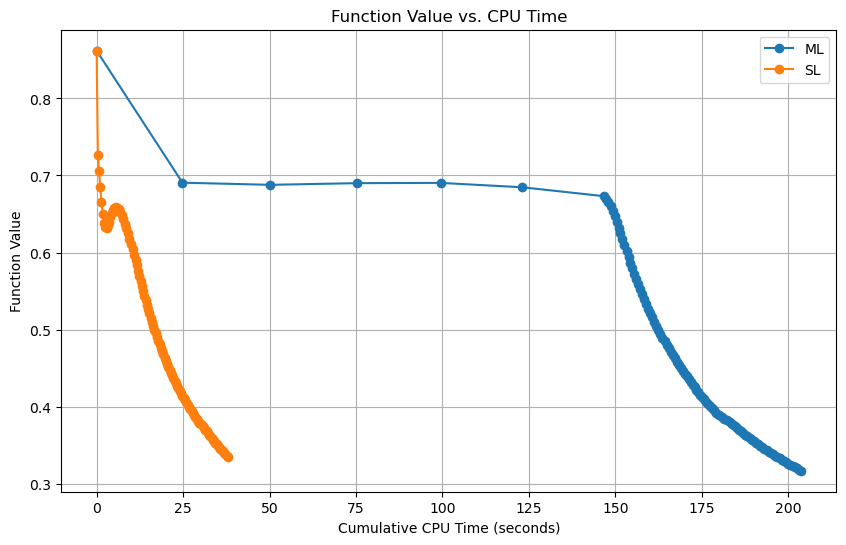

In [18]:
plt.figure(figsize=(10, 6))
#plt.plot(cumaltive_times_ML, fval_ML, marker='o', linestyle='-', label = 'ML')
#plt.plot(cumaltive_times_SL, fval_SL, marker='o', linestyle='-', label = 'SL')
plt.plot(cumaltive_times_ML, rel_f_err, marker='o', linestyle='-', label = 'ML')
plt.plot(cumaltive_times_SL, rel_f_err_SL, marker='o', linestyle='-', label = 'SL')
plt.xlabel('Cumulative CPU Time (seconds)')
plt.ylabel('Function Value')
plt.title('Function Value vs. CPU Time')
plt.grid(True)
plt.legend()
plt.show()

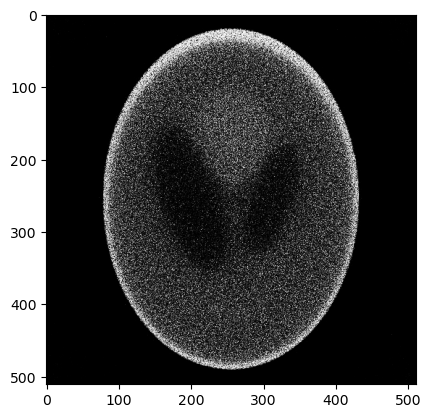

In [ ]:
plt.imshow(z0.detach().numpy(), cmap = 'gray')